<a href="https://colab.research.google.com/github/CAUKimJisu/Deep.Learn4AI_CAU/blob/main/FinalProject/AI%EB%94%A5%EB%9F%AC%EB%8B%9D_Team3_%EA%B9%80%EC%A7%80%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from keras.layers import Embedding
from sklearn.model_selection import train_test_split 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
SEED = 10

In [14]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.dropna(subset = ['text'], inplace = True)

X = df['text']
y = df['target']

### 01. EDA

Text(0.5, 1.0, 'Distribution of the Target Label')

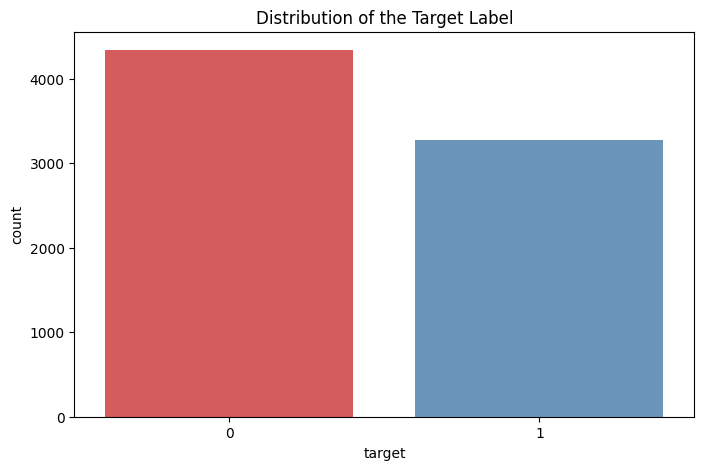

In [15]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['target'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the Target Label')

<ipython-input-16-628ea75b1643>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins = range(1, 50, 2), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of the word count')

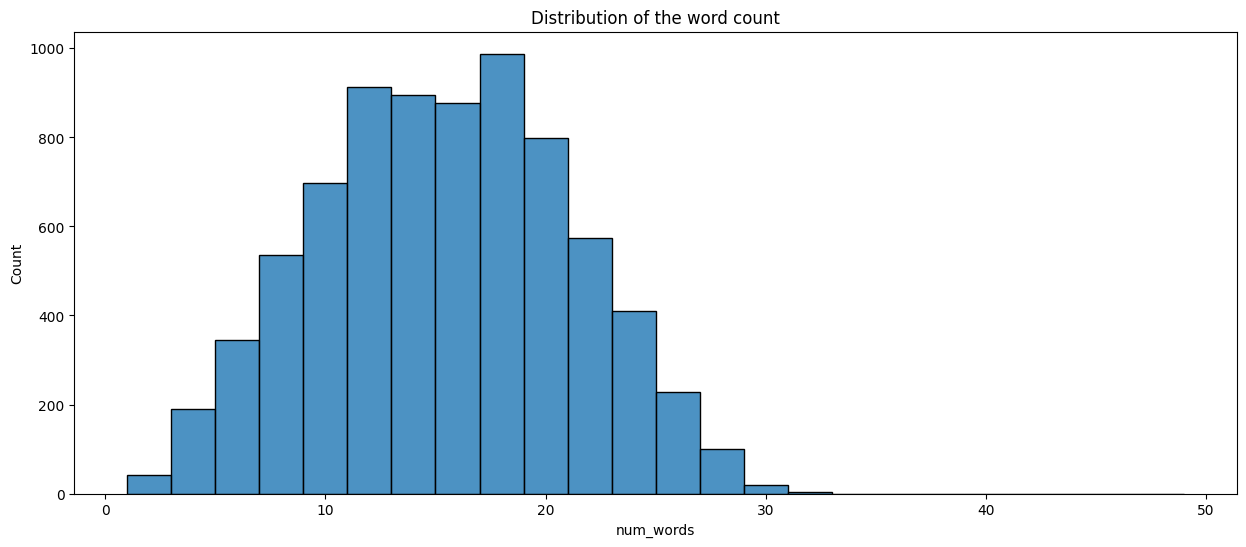

In [16]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (15,6))
sns.histplot(df['num_words'], bins = range(1, 50, 2), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the word count')

### 02. Define the model

In [19]:
def get_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[MAX_LEN]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

### 03. Train and evaluate

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

### 03-1. Train the model

In [25]:
MAX_LEN = 50

tok = Tokenizer()
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)


model = get_model()

history = model.fit(X_train_seq, y_train, 
                    epochs=50, validation_split = 0.2, batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=6, verbose=False,restore_best_weights=True)])

Epoch 1/50
153/153 [==============================] - 39s 157ms/step - loss: 0.6776 - accuracy: 0.5796 - val_loss: 0.6551 - val_accuracy: 0.5928
Epoch 2/50
153/153 [==============================] - 8s 53ms/step - loss: 0.5789 - accuracy: 0.7059 - val_loss: 0.4797 - val_accuracy: 0.7939
Epoch 3/50
153/153 [==============================] - 5s 30ms/step - loss: 0.3591 - accuracy: 0.8598 - val_loss: 0.4555 - val_accuracy: 0.8112
Epoch 4/50
153/153 [==============================] - 4s 24ms/step - loss: 0.2250 - accuracy: 0.9249 - val_loss: 0.4960 - val_accuracy: 0.7972
Epoch 5/50
153/153 [==============================] - 5s 31ms/step - loss: 0.1377 - accuracy: 0.9598 - val_loss: 0.7166 - val_accuracy: 0.7718
Epoch 6/50
153/153 [==============================] - 4s 23ms/step - loss: 0.0843 - accuracy: 0.9770 - val_loss: 0.7157 - val_accuracy: 0.7726
Epoch 7/50
153/153 [==============================] - 3s 20ms/step - loss: 0.0538 - accuracy: 0.9852 - val_loss: 0.8656 - val_accuracy: 0.75

### 03-2. Classification Report and Confusion Matrix

In [26]:
yhat =  np.where(model.predict(X_test_seq) >=0.5,1,0)

48/48 [==============================] - 2s 7ms/step


In [27]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.67      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



Text(70.72222222222221, 0.5, 'Real Labels')

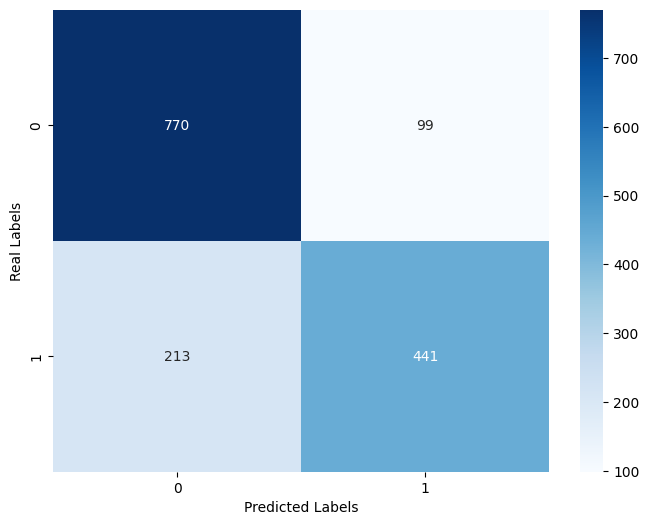

In [28]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### 04. StaratifiedKFold

In [30]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

X_test = df_test['text']
CV_score_array = []

y_test_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold+1},", end=' ')
    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    MAX_LEN = 50
    

    tok = Tokenizer()
    tok.fit_on_texts(X_train)


    sequences = tok.texts_to_sequences(X_train)
    valid_sequences = tok.texts_to_sequences(X_valid)
    test_sequences = tok.texts_to_sequences(X_test)


    X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
    X_valid_seq = pad_sequences(valid_sequences,maxlen=MAX_LEN)
    X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)
    

    model = get_model()

    history = model.fit(X_train_seq, y_train, epochs=50,
                    validation_data =(X_valid_seq, y_valid), batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=6, verbose=False,restore_best_weights=True)])


    yhat_valid =  np.where(model.predict(X_valid_seq) >=0.5,1,0)
    
    f_score = f1_score(y_valid,yhat_valid)
    print('F1 Score: ' + str(f_score))
    print(classification_report(y_valid,yhat_valid))
    
    y_test_list.append(model.predict(X_test_seq))

    CV_score_array.append(f_score)
    
print('Average F1 Score 5 Folds: ' + str(np.array(CV_score_array).mean()))

Fold: 1, Epoch 1/50
191/191 [==============================] - 35s 134ms/step - loss: 0.6664 - accuracy: 0.5939 - val_loss: 0.6142 - val_accuracy: 0.6763
Epoch 2/50
191/191 [==============================] - 5s 28ms/step - loss: 0.5009 - accuracy: 0.7722 - val_loss: 0.4544 - val_accuracy: 0.8011
Epoch 3/50
191/191 [==============================] - 6s 29ms/step - loss: 0.3060 - accuracy: 0.8867 - val_loss: 0.4753 - val_accuracy: 0.8017
Epoch 4/50
191/191 [==============================] - 4s 23ms/step - loss: 0.1874 - accuracy: 0.9356 - val_loss: 0.5936 - val_accuracy: 0.7984
Epoch 5/50
191/191 [==============================] - 4s 22ms/step - loss: 0.1124 - accuracy: 0.9663 - val_loss: 0.6377 - val_accuracy: 0.7892
Epoch 6/50
191/191 [==============================] - 4s 23ms/step - loss: 0.0702 - accuracy: 0.9806 - val_loss: 0.8155 - val_accuracy: 0.7820
Epoch 7/50
191/191 [==============================] - 4s 20ms/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 1.0363 - val_accur

### 05. Submission

In [31]:
df_sub = pd.read_csv('sample_submission.csv')

df_sub['target'] = np.where(np.mean(y_test_list, axis = 0) >=0.5, 1,0)
df_sub.to_csv('submission.csv', index = False)